# Vehicle Detection
---
John Bang - 4/28/17
### As a part of the Udacity Self Driving Car Engineer Nanodegree program, we use computer vision and supervised machine learning to detect the presence and location of vehicles on the road from the perspective of a moving car.

---

**Vehicle Detection Project**

The goals / steps of this project are the following:

1. [Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier](#HOG-feature-extraction)\*
2. Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.\*
3. Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
4. Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
5. Estimate a bounding box for vehicles detected.

\**Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.*

## Prepare Training Image Lists

8792 vehicle images
8968 non-vehicle images


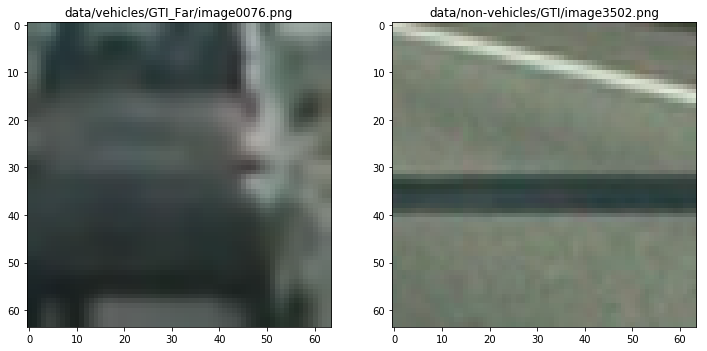

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

# Make lists of car and notcar files
cars = glob.glob('data/vehicles/*/*.png')
notcars = glob.glob('data/non-vehicles/*/*.png')

# Print number of each class
print(len(cars), "vehicle images")
print(len(notcars), "non-vehicle images")

# Plot a random example of each class
fig, ax = plt.subplots(1,2, figsize=(12,6))

plt.sca(ax[0])
car_example = np.random.choice(cars)
plt.imshow(mpimg.imread(car_example))
plt.title(car_example)
plt.sca(ax[1])
notcar_example = np.random.choice(notcars)
plt.imshow(mpimg.imread(notcar_example))
plt.title(notcar_example)

fig.savefig('output_images/train_images.jpg')

## HOG feature extraction

### 1. Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import itertools
import pandas as pd

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        image = np.uint8(image*255)

        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [5]:
RUNSWEEP = False

if RUNSWEEP:
    
    # Lists of parameters to permute
    colorspace_list = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
    orient_list = [6,9,12,15]
    pix_per_cell_list = [4,8,12,16]
    cell_per_block_list = [1,2,3,4]
    hog_channel_list = [0, 1, 2, 'ALL']
    
else:
    
    # Best parameters found through parameter sweep
    colorspace_list = ['YUV']
    orient_list = [12]
    pix_per_cell_list = [16]
    cell_per_block_list = [2]
    hog_channel_list = ['ALL']

# Construct list of parameter permutations
params = itertools.product(colorspace_list, orient_list, pix_per_cell_list,
                           cell_per_block_list, hog_channel_list)

entries = [] # list to store test result dicts

for colorspace, orient, pix_per_cell, cell_per_block, hog_channel in params:
    
    # initialize dict to store test result
    entry = {'colorspace':colorspace, 'orient':orient, 'pix_per_cell':pix_per_cell,
             'cell_per_block':cell_per_block, 'hog_channel':hog_channel}
    
    t=time.time()
    
    ########## Extract the HOG features
    car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
    notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract HOG features...')
    
    ########## Prepare feature vectors
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets (80/20 split)
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)
    
    # Fit a per-column scaler
    # Create a scaler which imposes zero-mean, unit variance on the training set
    X_scaler = StandardScaler().fit(X_train)
    # Apply the scaler to X
    X_train_scaled = X_scaler.transform(X_train)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    entry['nfeatures'] = len(X_train[0])
    
    ########## Train linear SVM classifier
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train_scaled, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    entry['train_secs'] = round(t2-t, 2)
    
    ########## Test the classifier
    # Check the score of the SVC
    X_test_scaled = X_scaler.transform(X_test)
    entry['test_accy'] = round(svc.score(X_test_scaled, y_test), 4)
    print('Test Accuracy of SVC = ', entry['test_accy'])
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    entry['n_predict'] = n_predict
    print('My SVC predicts: ', svc.predict(X_test_scaled[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    entry['predict_secs'] = round(t2-t, 5)
    print()
    
    ########### Fit scaler and train classifier with entire dataset
    X_scaler = StandardScaler().fit(X)
    X_scaled = X_scaler.transform(X)
    svc = LinearSVC()
    svc.fit(X_scaled, y)
    
    entries.append(entry) # append test result

# create test result dataframe for parameter sweep analysis/documentation
hog_classify_df = pd.DataFrame(entries)
hog_classify_df

129.1 Seconds to extract HOG features...
Using: 12 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1296
4.39 Seconds to train SVC...
Test Accuracy of SVC =  0.984
My SVC predicts:  [ 0.  1.  1.  1.  0.  1.  1.  1.  0.  0.]
For these 10 labels:  [ 0.  1.  1.  1.  0.  1.  1.  1.  0.  0.]
0.00524 Seconds to predict 10 labels with SVC



,cell_per_block,colorspace,hog_channel,n_predict,nfeatures,orient,pix_per_cell,predict_secs,test_accy,train_secs
0,2,YUV,ALL,10,1296,12,16,0.00524,0.984,4.39


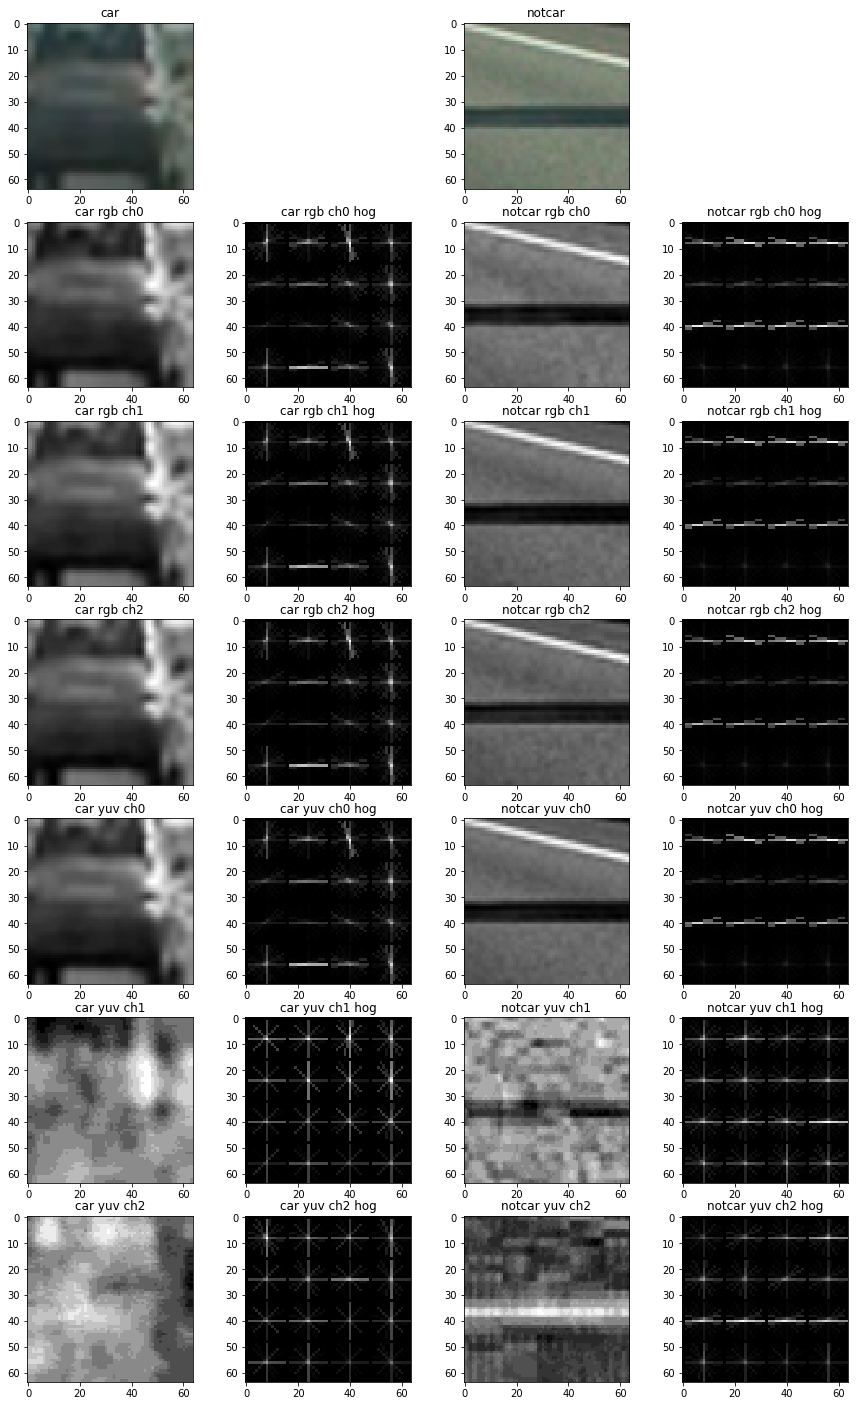

In [4]:
# Plot an example of HOG features for car and notcar, rgb and yuv
fig, ax = plt.subplots(7,4, figsize=(15, 25))

for image_idx, imagefile in enumerate([car_example, notcar_example]):
    
    if image_idx==0:
        titlestr0 = 'car'
    else:
        titlestr0 = 'notcar'

    image = mpimg.imread(imagefile)
    image = np.uint8(image*255)

    plt.sca(ax[0,0 + image_idx*2])
    plt.imshow(image)
    plt.title(titlestr0)
    fig.delaxes(ax[0,1 + image_idx*2])

    yuv_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    for color_idx, img in enumerate([image, yuv_image]):
        
        if color_idx==0:
            titlestr1 = titlestr0 + ' rgb'
        else:
            titlestr1 = titlestr0 + ' yuv'
        
        for ch in range(3):
            _,hog_image = get_hog_features(img[:,:,ch], orient, pix_per_cell, cell_per_block, vis=True)

            titlestr2 = titlestr1 + ' ch' + str(ch)
            
            plt.sca(ax[color_idx*3 + ch + 1,0 + image_idx*2])
            plt.imshow(img[:,:,ch], cmap='gray')
            plt.title(titlestr2)
            plt.sca(ax[color_idx*3 + ch + 1,1 + image_idx*2])
            plt.imshow(hog_image, cmap='gray')
            plt.title(titlestr2 + ' hog')

fig.savefig('output_images/hog_example.jpg', bbox_inches='tight')

In [ ]:
import numpy as np
import cv2
from skimage.feature import hog

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
# from lesson_functions import *

dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

img = mpimg.imread('test_image.jpg')

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img
    
ystart = 400
ystop = 656
scale = 1.5
    
out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)